In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import gensim
from time import time
import sqlite3

#metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
#creating dataframe from sql file
df=pd.read_csv("final.csv")

In [4]:
#taking 25k sample
df=df.sample(100000)
df.sort_values("Time",inplace=True)
df.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
427,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,im get crazi realli imposs today find french v...
241,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...


# Bag Of Words

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

#breaking data into train and test

X_train,X_test,Y_train,Y_test=train_test_split(df['CleanedText'].values,df['Score'].values,test_size=0.3,shuffle=False)

#text to unigram
unigram=CountVectorizer()
bow_train=unigram.fit_transform(X_train)
bow_test=unigram.transform(X_test)

#normalizing the data
bow_train=preprocessing.normalize(bow_train)
bow_test=preprocessing.normalize(bow_test)

print("shape of train  ",bow_train.shape)
print("shape of test ",bow_test.shape)

shape of train   (70000, 45372)
shape of test  (30000, 45372)


In [6]:
#10 fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=10)
for train,cv in tscv.split(bow_train):
    print(bow_train[train].shape,bow_train[cv].shape)

(6370, 45372) (6363, 45372)
(12733, 45372) (6363, 45372)
(19096, 45372) (6363, 45372)
(25459, 45372) (6363, 45372)
(31822, 45372) (6363, 45372)
(38185, 45372) (6363, 45372)
(44548, 45372) (6363, 45372)
(50911, 45372) (6363, 45372)
(57274, 45372) (6363, 45372)
(63637, 45372) (6363, 45372)


In [8]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

clf=DecisionTreeClassifier(class_weight='balanced')
param_grid={'max_depth':[1,5,10,50,100,500],
           'min_samples_split':[5,10,100,500]}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc',n_jobs=-1)
gsv.fit(bow_train,Y_train)

print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_*100)

Wall time: 0 ns
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 21.6min finished


best hyperparameter  {'max_depth': 50, 'min_samples_split': 500}
best score  79.4851172220069


In [9]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

In [12]:
print(gsv.cv_results_['params'])

[{'max_depth': 1, 'min_samples_split': 5}, {'max_depth': 1, 'min_samples_split': 10}, {'max_depth': 1, 'min_samples_split': 100}, {'max_depth': 1, 'min_samples_split': 500}, {'max_depth': 5, 'min_samples_split': 5}, {'max_depth': 5, 'min_samples_split': 10}, {'max_depth': 5, 'min_samples_split': 100}, {'max_depth': 5, 'min_samples_split': 500}, {'max_depth': 10, 'min_samples_split': 5}, {'max_depth': 10, 'min_samples_split': 10}, {'max_depth': 10, 'min_samples_split': 100}, {'max_depth': 10, 'min_samples_split': 500}, {'max_depth': 50, 'min_samples_split': 5}, {'max_depth': 50, 'min_samples_split': 10}, {'max_depth': 50, 'min_samples_split': 100}, {'max_depth': 50, 'min_samples_split': 500}, {'max_depth': 100, 'min_samples_split': 5}, {'max_depth': 100, 'min_samples_split': 10}, {'max_depth': 100, 'min_samples_split': 100}, {'max_depth': 100, 'min_samples_split': 500}, {'max_depth': 500, 'min_samples_split': 5}, {'max_depth': 500, 'min_samples_split': 10}, {'max_depth': 500, 'min_sampl

In [14]:
param=gsv.cv_results_['params']

In [10]:
print(train_auc)

[0.54767119 0.54767119 0.54767119 0.54767119 0.68249764 0.68240675
 0.68054693 0.67951634 0.77359358 0.77277982 0.76487248 0.76112183
 0.95179072 0.94930572 0.92789458 0.90299591 0.98383532 0.98205107
 0.96429753 0.94122484 0.99968936 0.99855011 0.98594891 0.96739355]


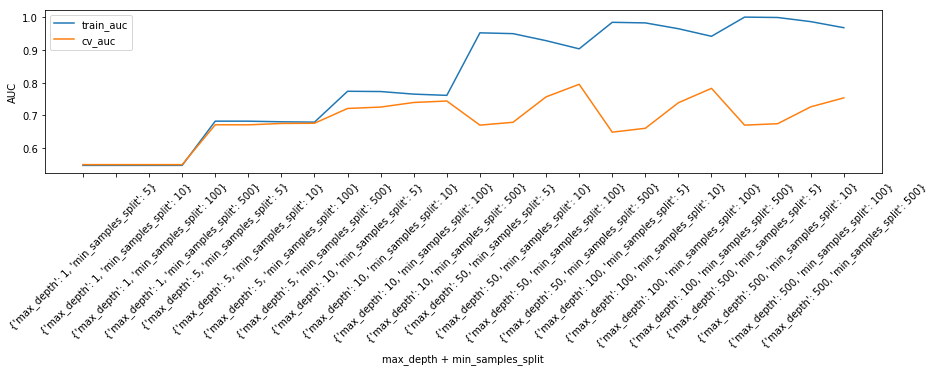

In [17]:
plt.figure(figsize=(15,3))
plt.plot(range(24),train_auc)
plt.plot(range(24),cv_auc)
plt.xticks(range(24),param,rotation = 45)
plt.xlabel("max_depth + min_samples_split")
plt.ylabel("AUC")
plt.legend(['train_auc','cv_auc'])
plt.show()

In [10]:
#testing on test data

clf=DecisionTreeClassifier(max_depth=10,min_samples_split=10,class_weight='balanced')
clf.fit(bow_train,Y_train)
Y_pred1=clf.predict(bow_train)
Y_pred2=clf.predict(bow_test)

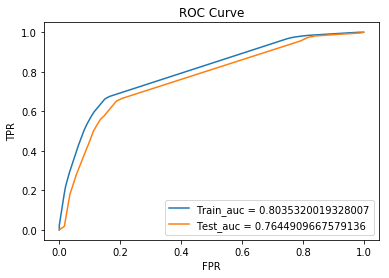

In [11]:
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(bow_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

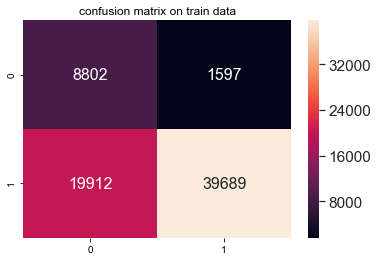

In [12]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

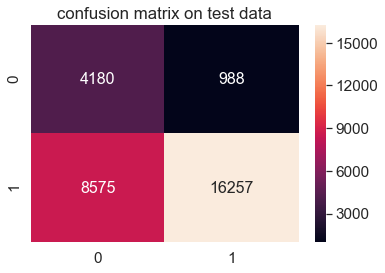

In [13]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

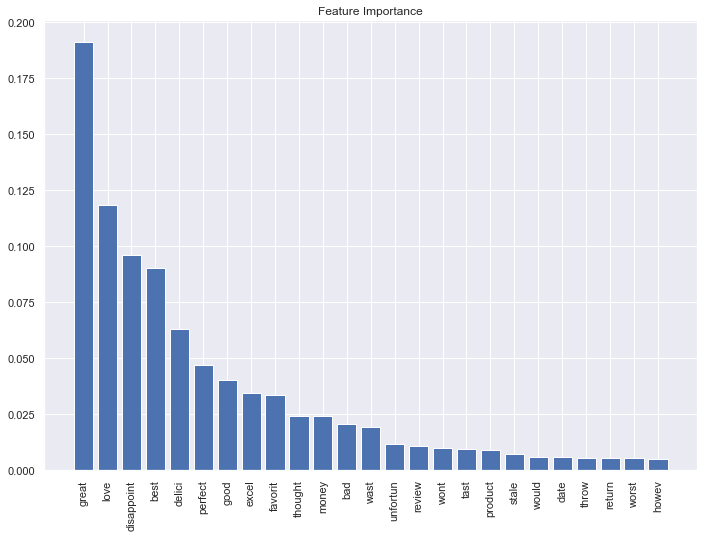

In [14]:
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1][:25]

names = unigram.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.figure()

plt.title("Feature Importance")

plt.bar(range(25), importances[indices])

names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

plt.show()


In [15]:
clf=DecisionTreeClassifier(max_depth=3)
clf.fit(bow_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

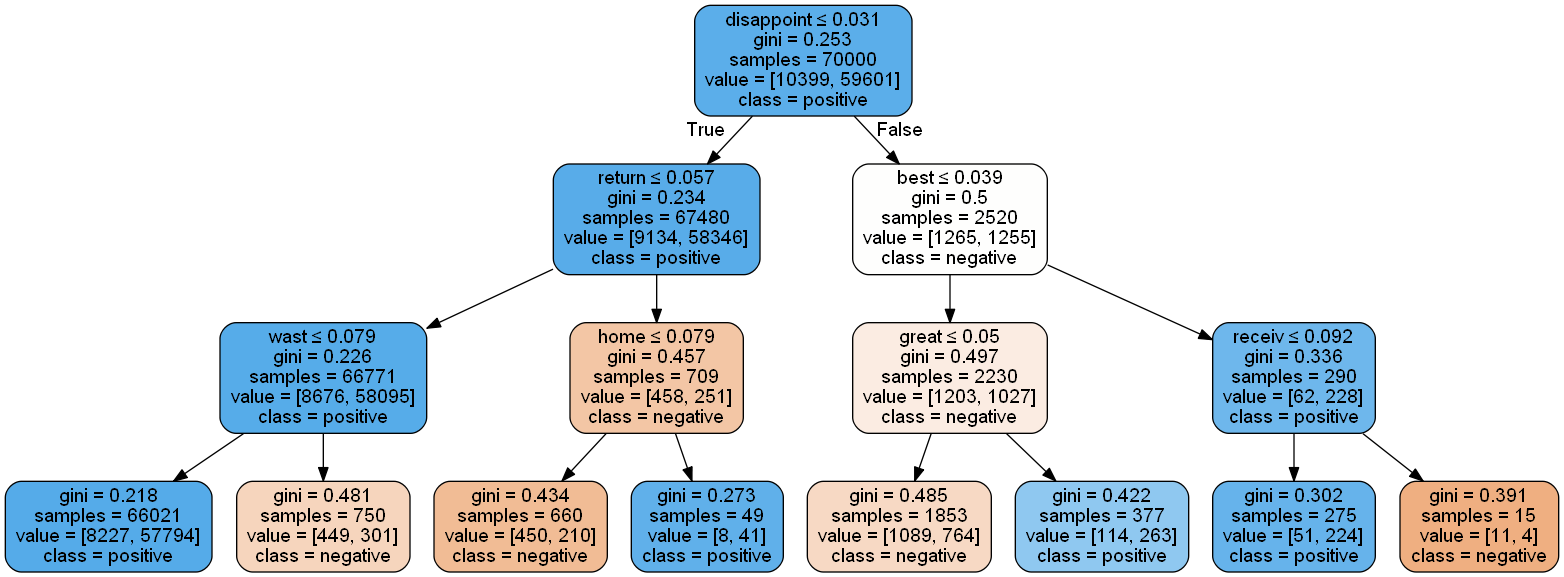

In [16]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(clf,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True,feature_names=names)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#graph = Source(data)

# Show graph
Image(graph.create_png())
#display(SVG(graph.pipe(format='svg')))

# Tfidf

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#text to unigram
tfidf=TfidfVectorizer()
tfidf_train=tfidf.fit_transform(X_train)
tfidf_test=tfidf.transform(X_test)

#normalizing the data
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_test=preprocessing.normalize(tfidf_test)

print("shape of train  ",tfidf_train.shape)
print("shape of test ",tfidf_test.shape)

shape of train   (70000, 45372)
shape of test  (30000, 45372)


In [18]:
clf=DecisionTreeClassifier(class_weight='balanced')
param_grid={'max_depth':[1,5,10,50,100,500],
           'min_samples_split':[5,10,100,500]}
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc',n_jobs=-1)
gsv.fit(tfidf_train,Y_train)

print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 17.2min finished


best hyperparameter  {'max_depth': 50, 'min_samples_split': 500}
best score  0.7800363921699038


In [20]:
train_auc=gsv.cv_results_['mean_train_score']
train_auc_std=gsv.cv_results_['std_train_score']
cv_auc=gsv.cv_results_['mean_test_score']
cv_auc_std=gsv.cv_results_['std_test_score']

In [21]:
param=gsv.cv_results_['params']

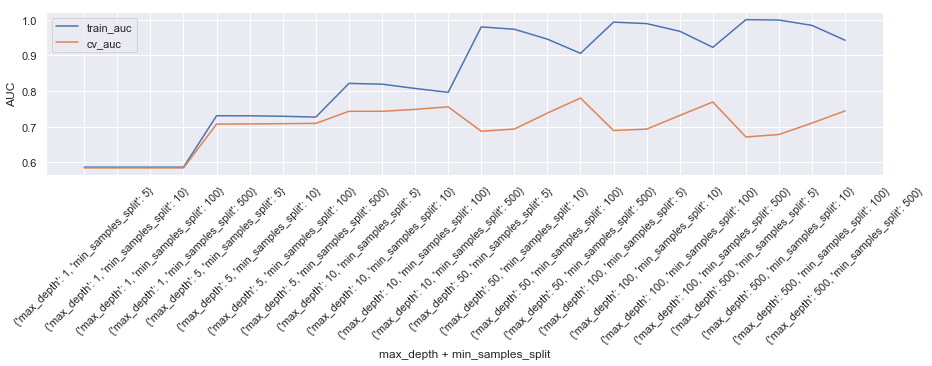

In [22]:
plt.figure(figsize=(15,3))
plt.plot(range(24),train_auc)
plt.plot(range(24),cv_auc)
plt.xticks(range(24),param,rotation = 45)
plt.xlabel("max_depth + min_samples_split")
plt.ylabel("AUC")
plt.legend(['train_auc','cv_auc'])
plt.show()

In [28]:
#testing on test data

clf=DecisionTreeClassifier(max_depth=10,min_samples_split=10,class_weight='balanced')
clf.fit(tfidf_train,Y_train)
Y_pred1=clf.predict(tfidf_train)
Y_pred2=clf.predict(tfidf_test)

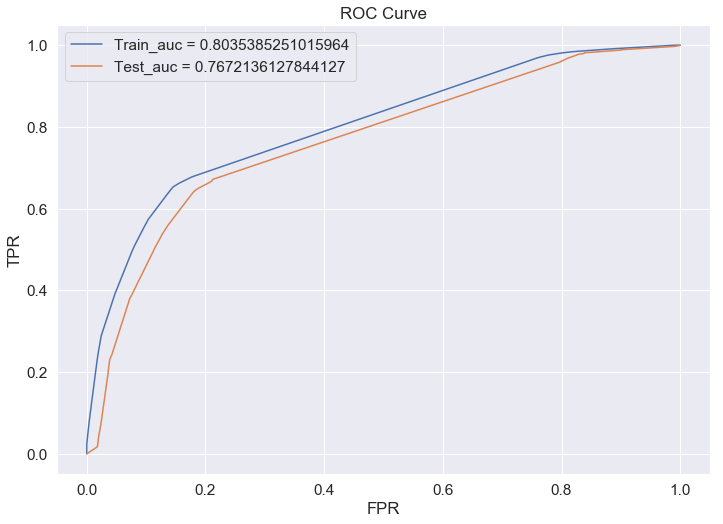

In [29]:
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(Y_train,clf.predict_proba(tfidf_train)[:,1])
test_fpr,test_tpr,threshold=roc_curve(Y_test,clf.predict_proba(tfidf_test)[:,1])

plt.plot(train_fpr,train_tpr,label="Train_auc = "+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test_auc = "+str(auc(test_fpr,test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

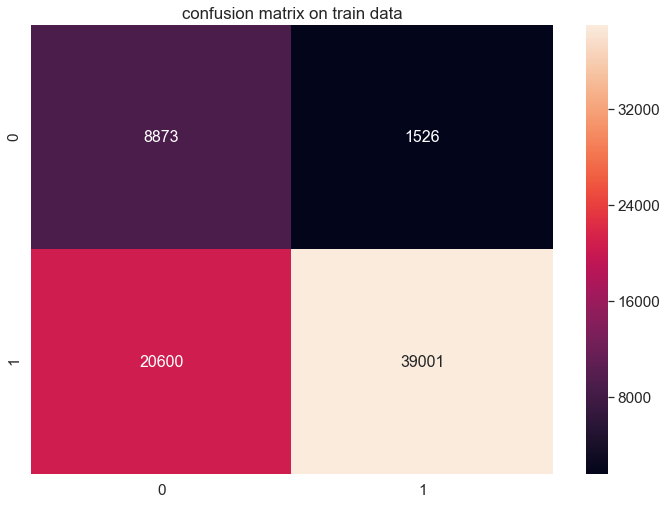

In [30]:
plt.title("confusion matrix on train data")
df_cm=pd.DataFrame(confusion_matrix(Y_train,Y_pred1),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

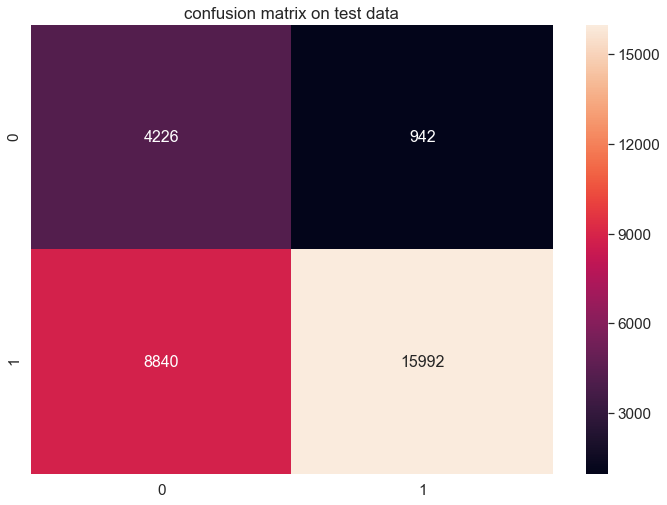

In [31]:
plt.title("confusion matrix on test data")
df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred2),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

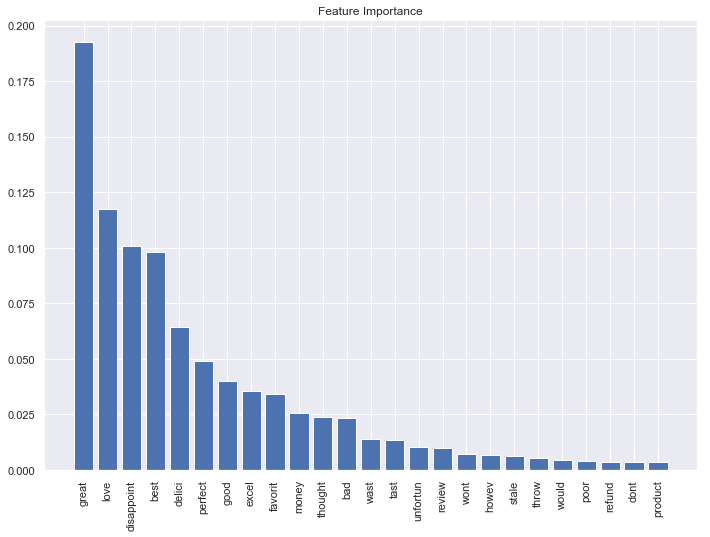

In [32]:
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1][:25]

names = tfidf.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.figure()

plt.title("Feature Importance")

plt.bar(range(25), importances[indices])

names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

plt.show()


In [33]:
clf=DecisionTreeClassifier(max_depth=3)
clf.fit(tfidf_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

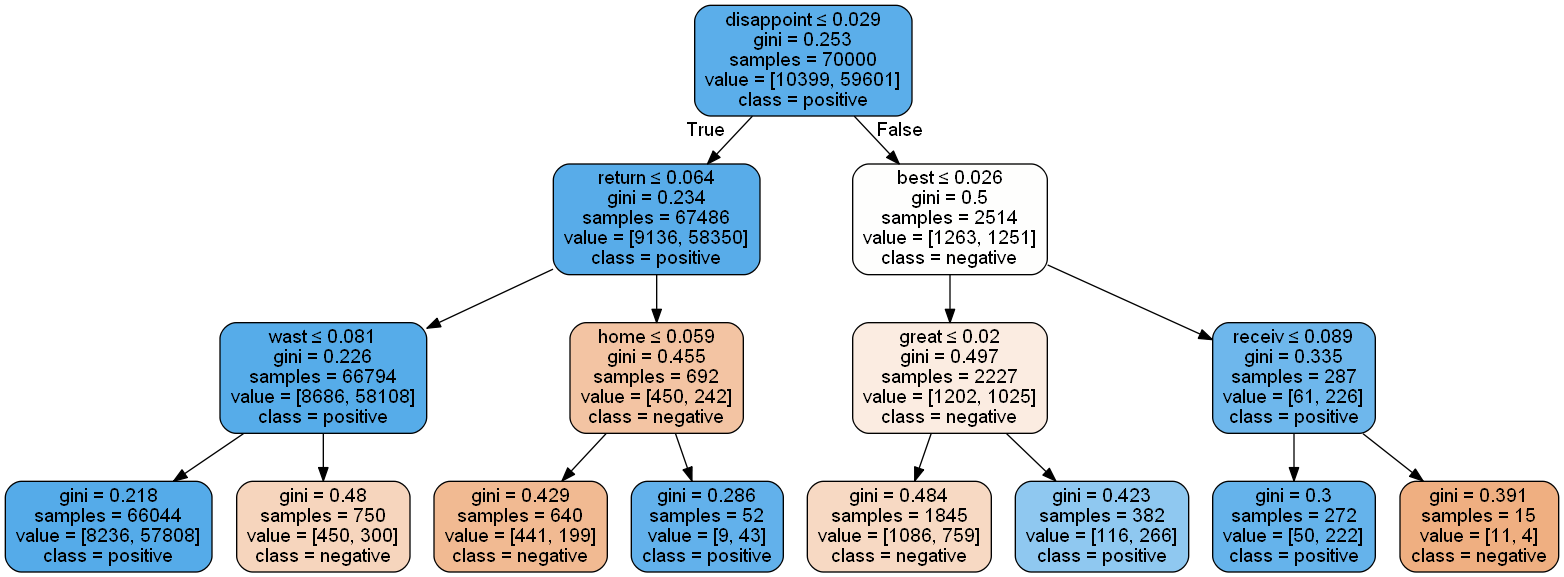

In [34]:

target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(clf,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True,feature_names=names)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#graph = Source(data)

# Show graph
Image(graph.create_png())
#display(SVG(graph.pipe(format='svg')))

# Word2Vec

In [37]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())
    
print(X_train[0])
print("*********a*********************************************")
print(list_of_sent_train[0])

rememb see show air televis year ago child sister later bought lp day im thirti someth use seri book &amp; song student teach preschool &amp; turn whole school purchas cd along book children 5 &amp; 2 tradit live
******************************************************
['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'lp', 'day', 'im', 'thirti', 'someth', 'use', 'seri', 'book', '&amp;', 'song', 'student', 'teach', 'preschool', '&amp;', 'turn', 'whole', 'school', 'purchas', 'cd', 'along', 'book', 'children', '5', '&amp;', '2', 'tradit', 'live']


In [38]:
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    
print(X_test[0])
print("*********a*********************************************")
print(list_of_sent_test[0])

oil solid hard packag look made 50 year old heart slow plus hear choir angel sing halleluja chorus ate it; mediocr popcorn mani unpop kernel fault - known like sausag better know movi theater popcorn made hint: yellow food dye essenti cannot bring eat
*********a*********************************************
['oil', 'solid', 'hard', 'packag', 'look', 'made', '50', 'year', 'old', 'heart', 'slow', 'plus', 'hear', 'choir', 'angel', 'sing', 'halleluja', 'chorus', 'ate', 'it;', 'mediocr', 'popcorn', 'mani', 'unpop', 'kernel', 'fault', '-', 'known', 'like', 'sausag', 'better', 'know', 'movi', 'theater', 'popcorn', 'made', 'hint:', 'yellow', 'food', 'dye', 'essenti', 'cannot', 'bring', 'eat']


In [ ]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)

C:\Users\ved\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [40]:
w2v_words=list(w2v_model.wv.vocab)
print("sample_words ",w2v_words[0:50])

sample_words  ['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'im', 'thirti', 'someth', 'use', 'seri', 'book', '&amp;', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'cd', 'along', 'children', '5', '2', 'tradit', 'live', 'beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'alway', 'enjoy', 'funni', 'entertain']


In [41]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.7973858118057251),
 ('yummi', 0.7883291244506836),
 ('satisfi', 0.6988962292671204),
 ('good', 0.6682137250900269),
 ('hearti', 0.6397491693496704),
 ('crispi', 0.6155579090118408),
 ('crunchi', 0.6125606298446655),
 ('nice', 0.6029852032661438),
 ('nutriti', 0.6015705466270447),
 ('crisp', 0.5970012545585632)]

# Average Word2Vec

In [42]:
from tqdm import tqdm
sent_vectors_train=[]
for sent in tqdm(list_of_sent_train):
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:57<00:00, 394.56it/s]


70000
50


In [ ]:
from tqdm import tqdm
sent_vectors_test=[]
for sent in tqdm(list_of_sent_test):
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

In [29]:
#normalize the avg w2v

avg_vec_norm=preprocessing.normalize(sent_vectors)

#splitting into train and test

X_train,X_test,Y_train,Y_test=train_test_split(avg_vec_norm,df['Score'].values,test_size=0.3,shuffle=False)
print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (17500, 50)
shape of test  (7500, 50)


In [30]:
clf=DecisionTreeClassifier()
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,Y_train)

print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.4min finished


best hyperparameter  {'max_depth': 10}
best score  0.9040660889738061


/home/ved/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


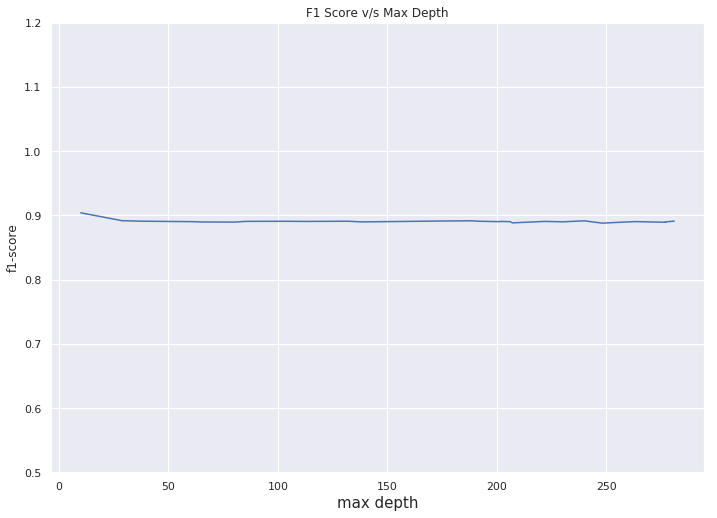

In [31]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
#plt.xlim(-10,300)
plt.ylim(0.5,1.2)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

accuracy on test 81.63f%
precision on test 87.02f%
recall on test 91.28f%
f1 on test 89.10f%
coonfusion matrix on test 
[[TN FP]
[FN TP]]



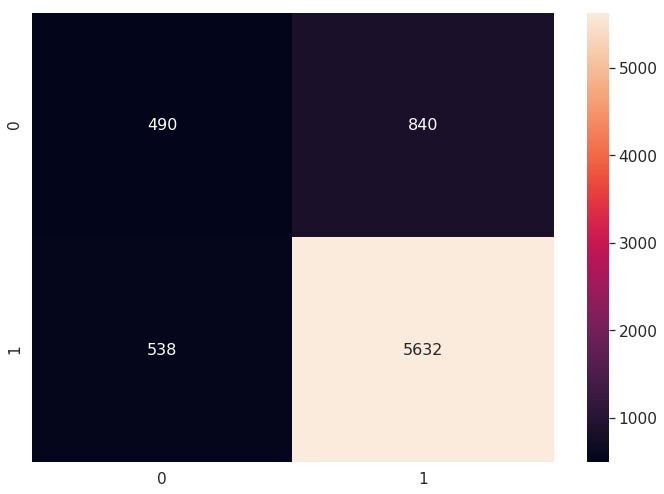

In [32]:
#testing on test data
clf=DecisionTreeClassifier(max_depth=10)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("coonfusion matrix on test \n[[TN FP]\n[FN TP]]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()

# Average Tfidf

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:

tfidf_feat = model.get_feature_names()

tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
             
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 25000/25000 [00:41<00:00, 603.84it/s]


In [36]:
tfidf_vect_norm=preprocessing.normalize(tfidf_sent_vectors)
#splitiing data into train and test
X_train,X_test,Y_train,Y_test=train_test_split(tfidf_vect_norm,df['Score'].values,test_size=0.3,shuffle=False)

print("shape of train ",X_train.shape)
print("shape of test ",X_test.shape)

shape of train  (17500, 50)
shape of test  (7500, 50)


In [37]:
clf=DecisionTreeClassifier()
gsv=GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,Y_train)

print("best hyperparameter ",gsv.best_params_)
print("best score ",gsv.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.7min finished


best hyperparameter  {'max_depth': 10}
best score  0.9051445889711182


/home/ved/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


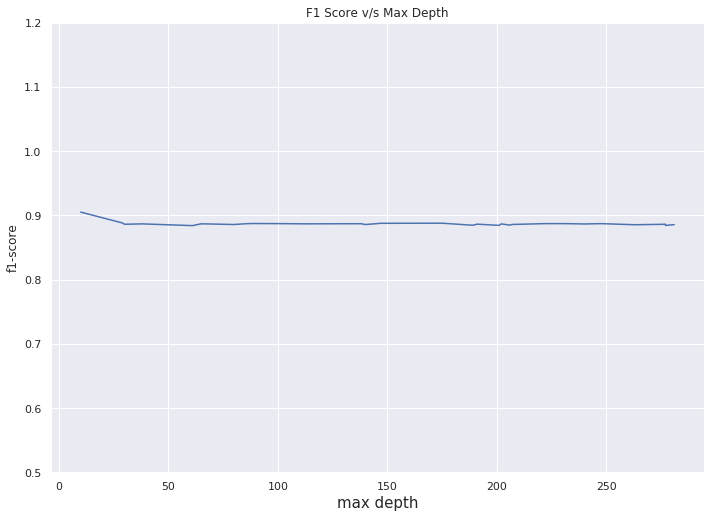

In [38]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
#plt.xlim(-10,300)
plt.ylim(0.5,1.2)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')
plt.plot(x,y)
plt.show()

accuracy on test 81.16f%
precision on test 85.53f%
recall on test 92.80f%
f1 on test 89.02f%
coonfusion matrix on test 
[[TN FP]
[FN TP]]



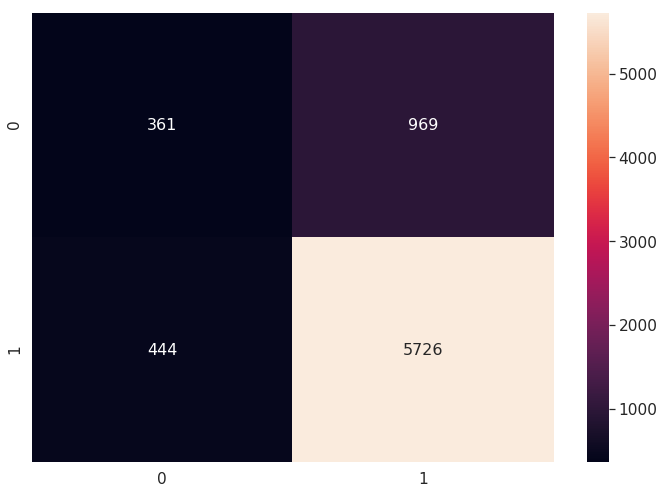

In [39]:
#testing on test data
clf=DecisionTreeClassifier(max_depth=10)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

print("accuracy on test %0.2ff%%"%(accuracy_score(Y_test,Y_pred)*100))
print("precision on test %0.2ff%%"%(precision_score(Y_test,Y_pred)*100))
print("recall on test %0.2ff%%"%(recall_score(Y_test,Y_pred)*100))
print("f1 on test %0.2ff%%"%(f1_score(Y_test,Y_pred)*100))
print("coonfusion matrix on test \n[[TN FP]\n[FN TP]]\n")

df_cm=pd.DataFrame(confusion_matrix(Y_test,Y_pred),range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={'size':16},fmt='g')
plt.show()